# 모델을 합치기 위한 Voting 가중치 산출
1. 이를 위해서 NLP와 non-NLP용 데이터가 한 데 모인 Validaion set을 따로 만듬
2. 이 새로운 dataset을 똑같은 방식으로 전처리 함
3. 두개 모델 각각에 대한 가중치를 조정해가면 최적 매개변수를 산출
4. Validation set의 종속변수의 비율이 skewed 되있기 때문에 판단 기준에 대한 조정이 필요
5. 결과:
    - 가중치 1:1
    - 판단 기준 0.4
    - 정확도 상승 F1(non-nlp: 0.55, nlp: 0.63 -> 0.678)

In [57]:
import pandas as pd
import datetime
import json
import numpy as np

In [2]:
blurb = pd.read_csv('blurb_validation_df.csv', index_col='Unnamed: 0')

In [3]:
oi = pd.read_csv('projects_fin.csv', index_col='Unnamed: 0')

In [4]:
projects = pd.merge(blurb, oi, left_on = 'name', right_on = 'name', how='inner')

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
projects.groupby('state_new').blurb.count().plot.bar(ylim=0)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

In [6]:
projects['launched_year'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[0], axis = 1)
projects['launched_month'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[1], axis = 1)
projects['launched_day'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[2], axis = 1)
projects['launched_date'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[1] + x['launched'].split(" ")[0].split("-")[2], axis = 1)

In [7]:
projects['deadline_dt'] = projects.apply(lambda x: datetime.datetime.strptime(x['deadline'], "%Y-%m-%d").date(), axis = 1)
projects['launched_dt'] = projects.apply(lambda x: datetime.datetime.strptime(x['launched'].split(" ")[0], "%Y-%m-%d").date(), axis = 1)

In [8]:
projects['term'] = projects.apply(lambda x: int(str(x['deadline_dt'] - x['launched_dt']).split(" ")[0]), axis = 1)
projects['term_str'] = projects.apply(lambda x: str(x['term']), axis = 1)

In [9]:
# launch 날짜가 1970년으로 되어있는 row는 삭제
projects_new = projects[lambda x: x['term'] < 100]

In [10]:
projects_new = projects_new.reset_index().drop(['index'], axis = 1)

In [11]:
projects_new['term_str'] = projects_new.apply(lambda x: x['term_str'] if len(x['term_str']) != 1
                                             else '0' + x['term_str'], axis = 1)

In [12]:
# binnarize the dependent variable
projects_new['state_bin'] = projects_new['state_new'].apply(lambda x: 0 if x == 'failed' else 1)

In [13]:
# 10만원 이하로 펀딩 받는 경우는 지움
projects_fin = projects_new[projects_new['usd_goal_real'] > 100]

In [14]:
train_data = projects_fin[['category', 'main_category', 'currency', 'country', 'usd_goal_real', 'state_bin', 'launched_year', 'launched_month', 'term', 'blurb']]

In [15]:
train = pd.DataFrame()

In [16]:
# lode vectorizatino labeling
with open('../non_nlp/cat_labels.json') as json_file:
    data = json.load(json_file)

In [17]:
# Assigning a categorical type to categorical varibles and vectorizing the categories for simplification

train['category'] = train_data['category'].map(data['category'])
train['main_category'] = train_data['main_category'].map(data['main_category'])
train['currency'] = train_data['currency'].map(data['currency'])
train['country'] = train_data['country'].map(data['country'])

In [18]:
train[['usd_goal_real', 'launched_year', 'launched_month', 'term', 'state', 'blurb']] = train_data[['usd_goal_real', 'launched_year', 'launched_month', 'term', 'state_bin', 'blurb']]

In [19]:
# remove NA values
train = train.dropna()

In [20]:
# turn categories into integer
train['category'] = train['category'].astype('int16')
train['main_category'] = train['main_category'].astype('int8')
train['currency'] = train['currency'].astype('int8')
train['country'] = train['country'].astype('int8')

In [21]:
train['launched_year'] = (train['launched_year']).astype('int')
train['launched_month'] = (train['launched_month']).astype('int')

In [22]:
col = list(train.columns)
col.remove('blurb')

x = train[col]
y_test = train['state']

# non-NLP Model

In [23]:
import pickle

In [24]:
cb_clf = pickle.load(open('../non_nlp/Non_nlp_model', 'rb'))

In [25]:
y_pred = cb_clf.predict(x)

In [26]:
from sklearn.metrics import accuracy_score, f1_score

In [27]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.5555555555555555, 0.6902050113895216)

In [28]:
peta = pd.read_csv("df_text_eng.csv")

In [29]:
del peta['Unnamed: 0'] 
from io import StringIO
peta['state_id'] = peta['state'].factorize()[0]
state_id_df = peta[['state', 'state_id']].drop_duplicates().sort_values('state_id')
state_to_id = dict(state_id_df.values)
id_to_state = dict(state_id_df[['state_id', 'state']].values)

In [30]:
import re
def clean(text):
    text = str(text)
    text = re.findall(r'\w+', text)
    return ' '.join(text)
peta['blurb'] = peta['blurb'].apply(lambda x: clean(x))

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
x_train, x_zeta, y_zeta, y_peta = train_test_split(peta['blurb'], peta['state'], train_size=0.7, random_state=42)
vectorizer = TfidfVectorizer().fit(x_train)

# NLP Model

In [32]:
import re
def clean(text):
    text = str(text)
    text = re.findall(r'\w+', text)
    return ' '.join(text)
train['blurb'] = train['blurb'].apply(lambda x: clean(x))

In [33]:
x_blurb = train['blurb'].copy()

x_blurb_vec = vectorizer.transform(x_blurb)

In [34]:
lg_clf = pickle.load(open('../nlp/nlp_model.sav', 'rb'))

In [35]:
result = pd.DataFrame(lg_clf.predict(x_blurb_vec))

In [36]:
y_pred = result[0].apply(lambda x: 0 if x == 'failed' else 1)

In [37]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.63919259882254, 0.6742596810933941)

# Voting Parameter

In [38]:
ratio = np.arange(0, 1.01, 0.01)
y_ratio_pred = np.arange(0, 1.01, 0.01)
x1 = np.arange(0, 1.01, 0.01)
y2 = np.arange(0, 1.01, 0.01)
z2 = np.arange(0, 1.01, 0.01)

for r in ratio:
    y_ratio_pred = (cb_clf.predict_proba(x)*r + lg_clf.predict_proba(x_blurb_vec)*(1-r))[:,1]
    y_ratio_pred = (y_ratio_pred > 0.5).astype(int)
    y2[int(r*100)] = accuracy_score(y_test, y_ratio_pred)
    z2[int(r*100)] = f1_score(y_test, y_ratio_pred)

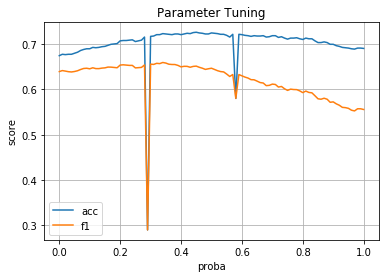

In [39]:
ax = plt.subplot(111)

ax.plot(x1, y2, label='acc')
ax.plot(x1, z2, label='f1')

ax.set(xlabel='proba', ylabel='score', title='Parameter Tuning')
ax.legend(loc='lower left')
ax.grid()

proba = non-NLP에 대한 가중치
1 - proba = NLP에 대한 가중치

In [40]:
max(y2), max(z2)

(0.7258921791951405, 0.6591970121381886)

In [41]:
y_ratio_pred = (cb_clf.predict_proba(x)*0.34 + lg_clf.predict_proba(x_blurb_vec)*(0.66))[:,1] > 0.5

In [47]:
y_final_pred = (cb_clf.predict_proba(x)*0.34 + lg_clf.predict_proba(x_blurb_vec)*(0.66))[:,1]

In [48]:
y_ratio_pred = y_ratio_pred.astype(int)

In [49]:
accuracy_score(y_test, y_ratio_pred), f1_score(y_test, y_ratio_pred)

(0.7228549734244495, 0.6591970121381886)

## Proba Manipulation of 33:67
- 판단 기준을 0.4로 설정한 근거


In [50]:
x1 = np.arange(0, 1.01, 0.01)
y1 = np.arange(0, 1.01, 0.01)
z1 = np.arange(0, 1.01, 0.01)
r1 = np.full((101, ), 0.6)

from sklearn.metrics import accuracy_score, f1_score

for i in np.arange(0, 1.01, 0.01):
    y_proba = ((y_final_pred) > i).astype(int)
    y1[int(i*100)] = accuracy_score(y_test, y_proba)
    z1[int(i*100)] = f1_score(y_test, y_proba)

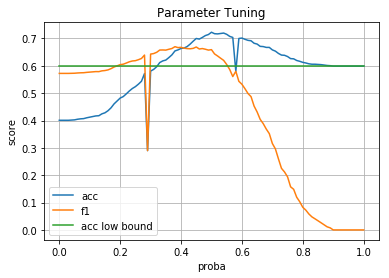

In [51]:
ax = plt.subplot(111)

ax.plot(x1, y1, label='acc')
ax.plot(x1, z1, label='f1')
ax.plot(x1, r1, label='acc low bound')

ax.set(xlabel='proba', ylabel='score', title='Parameter Tuning')
ax.legend(loc='lower left')
ax.grid()

In [52]:
print('max accuracy:', max(y1))
print('max f1 score:', max(z1))

max accuracy: 0.7228549734244495
max f1 score: 0.6700507614213199


# Simple 1:1 Voting Proba Manipulation

In [53]:
y_final_pred = (cb_clf.predict_proba(x) + lg_clf.predict_proba(x_blurb_vec))[:,1] /2

In [54]:
x1 = np.arange(0, 1.01, 0.01)
y1 = np.arange(0, 1.01, 0.01)
z1 = np.arange(0, 1.01, 0.01)
r1 = np.full((101, ), 0.6)

from sklearn.metrics import accuracy_score, f1_score

for i in np.arange(0, 1.01, 0.01):
    y_proba = ((y_final_pred) > i).astype(int)
    y1[int(i*100)] = accuracy_score(y_test, y_proba)
    z1[int(i*100)] = f1_score(y_test, y_proba)

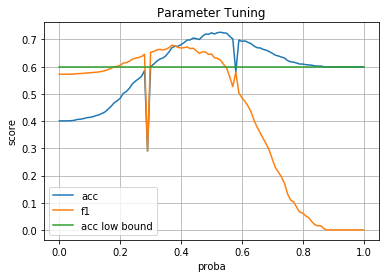

In [55]:
ax = plt.subplot(111)

ax.plot(x1, y1, label='acc')
ax.plot(x1, z1, label='f1')
ax.plot(x1, r1, label='acc low bound')

ax.set(xlabel='proba', ylabel='score', title='Parameter Tuning')
ax.legend(loc='lower left')
ax.grid()

In [56]:
print('max accuracy:', max(y1))
print('max f1 score:', max(z1))

max accuracy: 0.7266514806378133
max f1 score: 0.6789667896678967
